In [16]:
##1. Imports

In [42]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [18]:
df = pd.read_csv("final_merged_data.csv")

# convert dates again if needed
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])

df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,...,customer_state,review_score,price,freight_value,items_count,product_category,is_unhappy,delivery_delay_days,delay_bucket,freight_to_price_ratio
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,...,SP,4.0,29.99,8.72,1.0,cool_stuff,0,-8.0,On Time,0.290764
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13,af07308b275d755c9edb36a90c618231,47813,...,BA,4.0,118.70,22.76,1.0,pet_shop,0,-6.0,On Time,0.191744
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,...,GO,5.0,159.90,19.22,1.0,furniture_decor,0,-18.0,On Time,0.120200
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,...,RN,5.0,45.00,27.20,1.0,perfumery,0,-13.0,On Time,0.604444
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,...,SP,5.0,19.90,8.72,1.0,garden_tools,0,-10.0,On Time,0.438191


In [19]:
df.shape, df.columns


((96934, 21),
 Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
        'order_approved_at', 'order_delivered_carrier_date',
        'order_delivered_customer_date', 'order_estimated_delivery_date',
        'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
        'customer_state', 'review_score', 'price', 'freight_value',
        'items_count', 'product_category', 'is_unhappy', 'delivery_delay_days',
        'delay_bucket', 'freight_to_price_ratio'],
       dtype='object'))

In [20]:
# snapshot date = one day after last purchase
snapshot_date = df["order_purchase_timestamp"].max() + pd.Timedelta(days=1)

rfm = (
    df.groupby("customer_unique_id")
      .agg({
          "order_purchase_timestamp": lambda x: (snapshot_date - x.max()).days,
          "order_id": "nunique",
          "price": "sum"
      })
      .reset_index()
)

rfm.columns = ["customer_unique_id", "Recency", "Frequency", "Monetary"]

rfm.head()


,customer_unique_id,Recency,Frequency,Monetary
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90
2,0000f46a3911fa3c0805444483337064,537,1,69.00
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00


In [21]:
rfm.describe()


,Recency,Frequency,Monetary
count,93293.000000,93293.000000,93293.000000
mean,237.961830,1.033357,142.336431
std,152.590117,0.208258,216.977418
min,1.000000,1.000000,3.500000
25%,114.000000,1.000000,47.900000
50%,219.000000,1.000000,89.900000
75%,346.000000,1.000000,155.000000
max,714.000000,15.000000,13440.000000


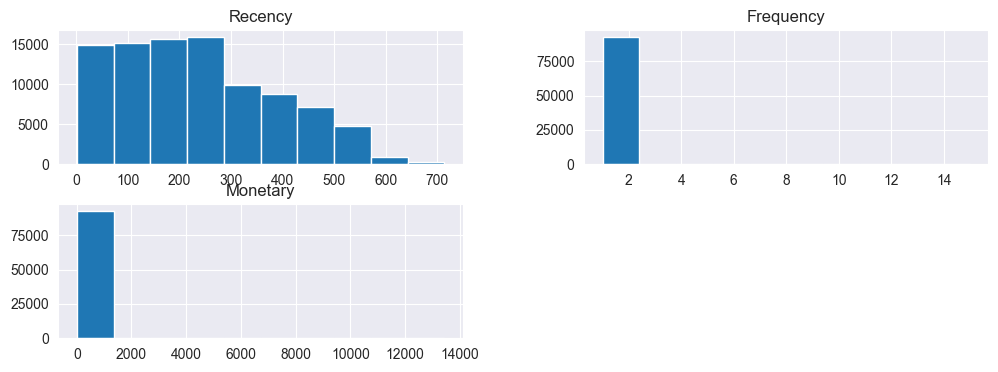

In [22]:
rfm.hist(figsize=(12,6))
plt.show()


In [23]:
scaler = StandardScaler()

rfm_scaled = scaler.fit_transform(
    rfm[["Recency", "Frequency", "Monetary"]]
)


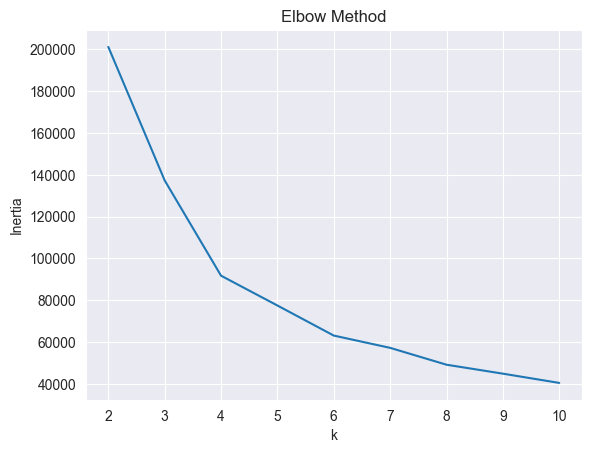

In [24]:
inertia = []

for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(rfm_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2,11), inertia)
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()


In [25]:
for k in range(2, 11):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    print(f"k={k} -> Silhouette Score: {score:.3f}")


k=2 -> Silhouette Score: 0.742
k=3 -> Silhouette Score: 0.460
k=4 -> Silhouette Score: 0.491
k=5 -> Silhouette Score: 0.503
k=6 -> Silhouette Score: 0.440
k=7 -> Silhouette Score: 0.447
k=8 -> Silhouette Score: 0.451
k=9 -> Silhouette Score: 0.399
k=10 -> Silhouette Score: 0.403


In [26]:
kmeans = KMeans(n_clusters=4, random_state=42)
rfm["cluster"] = kmeans.fit_predict(rfm_scaled)

rfm.head()
cluster_profile = (
    rfm.groupby("cluster")[["Recency", "Frequency", "Monetary"]]
       .mean()
       .round(2)
)

cluster_profile


,customer_unique_id,Recency,Frequency,Monetary,cluster
0,0000366f3b9a7992bf8c76cfdf3221e2,112,1,129.90,1
1,0000b849f77a49e4a4ce2b2a4ca5be3f,115,1,18.90,1
2,0000f46a3911fa3c0805444483337064,537,1,69.00,2
3,0000f6ccb0745a6a4b88665a16c9f078,321,1,25.99,2
4,0004aac84e0df4da2b147fca70cf8255,288,1,180.00,2


In [29]:
cluster_profile = (
    rfm.groupby("cluster")[["Recency", "Frequency", "Monetary"]]
       .mean()
       .round(2)
)

cluster_profile


,Recency,Frequency,Monetary
cluster,,,
0,220.30,2.11,258.25
1,128.51,1.00,113.55
2,387.91,1.00,114.52
3,237.51,1.02,1150.50


In [30]:
joblib.dump(kmeans, "rfm_kmeans.pkl")
joblib.dump(scaler, "rfm_scaler.pkl")
rfm.to_csv("rfm_segmented_customers.csv", index=False)


In [31]:
rfm["cluster"].value_counts().sort_index()

cluster
0     2766
1    50883
2    37475
3     2169
Name: count, dtype: int64

In [33]:
cluster_names = {
    0: "Repeat Customers",
    1: "New Customers",
    2: "Churned Customers",
    3: "High-Value Customers"
}

rfm["segment"] = rfm["cluster"].map(cluster_names)


In [34]:
import joblib

joblib.dump(kmeans, "rfm_kmeans.pkl")
joblib.dump(scaler, "rfm_scaler.pkl")
rfm.to_csv("rfm_segmented_customers.csv", index=False)


In [36]:
# daily revenue
daily_sales = (
    df.groupby(df["order_purchase_timestamp"].dt.date)["price"]
      .sum()
      .reset_index()
)

daily_sales.columns = ["date", "sales"]
daily_sales["date"] = pd.to_datetime(daily_sales["date"])

daily_sales.head(), daily_sales.tail()


(        date    sales
 0 2016-09-15   134.97
 1 2016-10-03   441.98
 2 2016-10-04  8595.89
 3 2016-10-05  6169.77
 4 2016-10-06  5889.96,
           date     sales
 607 2018-08-25  10597.21
 608 2018-08-26   8070.71
 609 2018-08-27   5345.91
 610 2018-08-28   3673.91
 611 2018-08-29   1546.04)

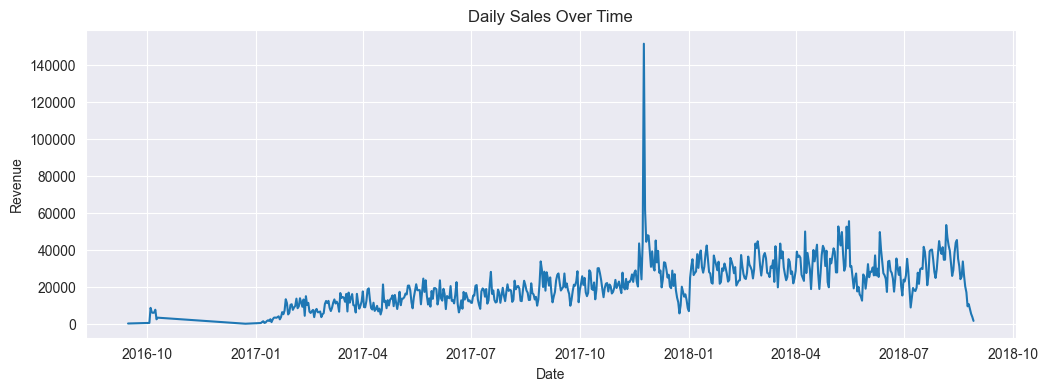

In [37]:
plt.figure(figsize=(12,4))
plt.plot(daily_sales["date"], daily_sales["sales"])
plt.title("Daily Sales Over Time")
plt.xlabel("Date")
plt.ylabel("Revenue")
plt.show()


In [38]:
# ds = date
# y  = value
ts_df = daily_sales.rename(columns={
    "date": "ds",
    "sales": "y"
})

ts_df.head()


,ds,y
0,2016-09-15,134.97
1,2016-10-03,441.98
2,2016-10-04,8595.89
3,2016-10-05,6169.77
4,2016-10-06,5889.96


In [39]:
split_date = ts_df["ds"].quantile(0.8)

train = ts_df[ts_df["ds"] <= split_date]
test  = ts_df[ts_df["ds"] > split_date]

train.shape, test.shape


((489, 2), (123, 2))

In [43]:
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)

model.fit(train)


11:55:21 - cmdstanpy - INFO - Chain [1] start processing
11:55:24 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
future_test = model.make_future_dataframe(periods=len(test))
forecast_test = model.predict(future_test)


In [45]:
forecast_eval = forecast_test.tail(len(test))

y_true = test["y"].values
y_pred = forecast_eval["yhat"].values


In [46]:
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

mae, rmse


(10176.232038682683, np.float64(13171.948550403986))

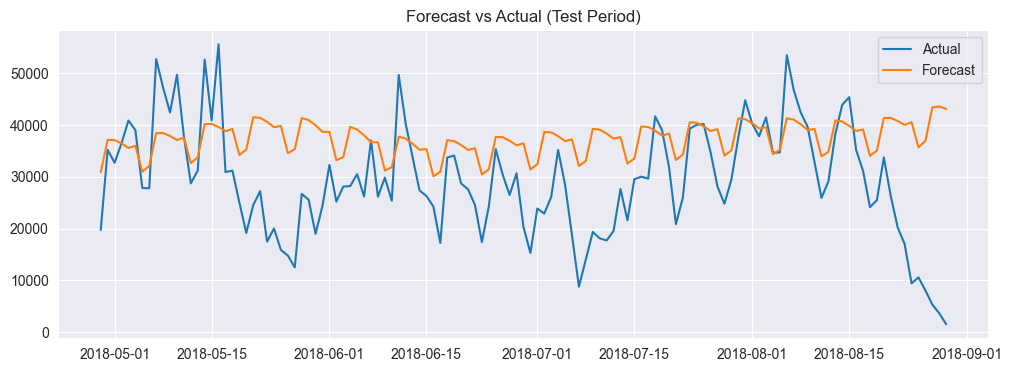

In [47]:
plt.figure(figsize=(12,4))
plt.plot(test["ds"], y_true, label="Actual")
plt.plot(test["ds"], y_pred, label="Forecast")
plt.legend()
plt.title("Forecast vs Actual (Test Period)")
plt.show()


In [48]:
holidays = pd.DataFrame({
    "holiday": "promo",
    "ds": pd.to_datetime([
        "2017-11-24",  # Black Friday
        "2018-11-23"
    ]),
    "lower_window": 0,
    "upper_window": 1,
})

model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    holidays=holidays
)


In [49]:
train_log = train.copy()
train_log["y"] = np.log1p(train_log["y"])

model.fit(train_log)

future_test = model.make_future_dataframe(periods=len(test))
forecast_test = model.predict(future_test)

y_pred = np.expm1(forecast_test.tail(len(test))["yhat"])


11:57:58 - cmdstanpy - INFO - Chain [1] start processing
11:57:58 - cmdstanpy - INFO - Chain [1] done processing


In [50]:
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

forecast.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,holidays,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
574,2018-07-23,9.295691,8.971527,10.042236,9.216461,9.384670,0.186265,0.186265,0.186265,0.0,...,0.114939,0.114939,0.114939,0.071326,0.071326,0.071326,0.0,0.0,0.0,9.481956
575,2018-07-24,9.289592,8.969130,10.088745,9.208364,9.381010,0.242298,0.242298,0.242298,0.0,...,0.177934,0.177934,0.177934,0.064364,0.064364,0.064364,0.0,0.0,0.0,9.531890
576,2018-07-25,9.283492,8.908863,10.001320,9.201403,9.376567,0.180092,0.180092,0.180092,0.0,...,0.123809,0.123809,0.123809,0.056284,0.056284,0.056284,0.0,0.0,0.0,9.463585
577,2018-07-26,9.277393,8.838081,9.928806,9.194252,9.371979,0.082719,0.082719,0.082719,0.0,...,0.035490,0.035490,0.035490,0.047229,0.047229,0.047229,0.0,0.0,0.0,9.360112
578,2018-07-27,9.271294,8.714318,9.777952,9.187077,9.367439,-0.004793,-0.004793,-0.004793,0.0,...,-0.042159,-0.042159,-0.042159,0.037366,0.037366,0.037366,0.0,0.0,0.0,9.266501


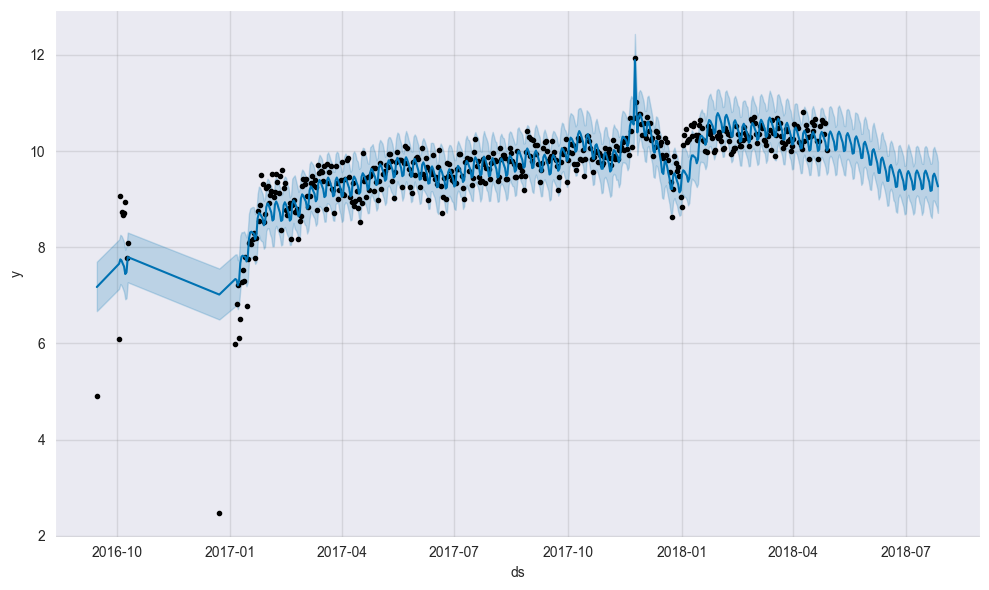

In [51]:
model.plot(forecast)
plt.show()


In [52]:
import joblib

joblib.dump(model, "sales_forecast_prophet.pkl")


['sales_forecast_prophet.pkl']

In [53]:
forecast.to_csv("sales_forecast_90days.csv", index=False)
